# **Objective**
Analyze and optimize a diversified portfolio of 10 assets over a 10-year period using historical data, performance metrics, and risk-adjusted optimization techniques.


## Import Necessary Library

In [3]:

import yfinance as yf 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.optimize import minimize
from datetime import datetime



# **1. Data Acquisition**
- Downloaded historical prices (2014–2024) using `yfinance` for AAPL, MSFT, AMZN, TSLA, JPM, SPY, QQQ, GLD, BTC-USD, ETH-USD.
- Included both adjusted and unadjusted close prices.

In [5]:
# Asset tickers 
assets = ['AAPL', 'MSFT', 'AMZN', 'TSLA', 'JPM', 'SPY', 'QQQ', 'GLD', 'BTC-USD', 'ETH-USD']
start_date = '2014-01-01' 
end_date = datetime.today().strftime('%Y-%m-%d')

# Download Data
data = yf.download(assets, start = start_date , end = end_date, group_by='ticker', auto_adjust = False)


[*********************100%***********************]  10 of 10 completed


In [6]:
# Extract adjusted close and close prices
adj_close = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in assets}) 
close = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in assets})


In [7]:
adj_close.sample(10)

,AAPL,MSFT,AMZN,TSLA,JPM,SPY,QQQ,GLD,BTC-USD,ETH-USD
Date,,,,,,,,,,
2015-07-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,260.885986,NaN
2014-05-22,19.119728,33.937336,15.245500,13.658667,40.361088,156.450882,81.733650,124.669998,NaN,NaN
2018-04-16,41.484863,87.483856,72.074997,19.414000,90.326729,238.945206,155.115005,127.629997,8058.669922,511.147003
2018-04-24,38.445824,86.508423,73.004501,18.897333,90.490654,235.057114,151.165558,126.230003,9697.500000,708.158020
2019-12-09,64.622513,144.483963,87.475502,22.635332,115.017357,288.713562,197.190613,137.580002,7400.899414,148.225174
2021-02-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56099.519531,1919.534058
2018-10-15,51.664581,100.779930,88.047501,17.306000,88.242203,247.481140,164.930496,116.000000,6596.540039,209.703995
2014-08-27,22.620703,38.211445,17.159000,17.549999,44.398361,166.039459,91.404121,123.320000,NaN,NaN
2018-10-10,51.426891,99.431229,87.762497,17.125334,92.499130,250.998520,164.470810,112.879997,6585.529785,225.768997


In [8]:
close.sample(10)

,AAPL,MSFT,AMZN,TSLA,JPM,SPY,QQQ,GLD,BTC-USD,ETH-USD
Date,,,,,,,,,,
2019-07-19,50.647499,136.619995,98.225998,17.212000,113.540001,297.170013,191.009995,134.470001,10530.732422,221.333420
2022-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42190.652344,2946.257080
2018-05-31,46.717499,98.839996,81.481003,18.982000,107.010002,270.940002,170.070007,123.099998,7494.169922,577.645020
2021-04-19,134.839996,258.739990,168.600494,238.210007,152.649994,415.209991,338.880005,165.889999,55724.265625,2166.188721
2024-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,95163.929688,3397.902344
2015-05-27,33.009998,47.610001,21.570999,16.495333,66.470001,212.699997,110.959999,113.889999,237.283005,NaN
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,281.601013,NaN
2023-11-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37054.519531,2045.187012
2019-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5337.886230,173.751266


# **2. Preprocessing**
- Interpolated missing values.
- Removed rows with too many NaNs.
- Calculated daily returns.

In [10]:
# Interpolate small gaps
adj_close = adj_close.interpolate(method='linear', limit=5, axis=0)

# Forward-fill or drop large gaps 
def clean_missing(df, max_gap=5): 
    mask = df.isna()
    gap_sizes = mask.cumsum().where(mask).fillna(0).astype(int) 
    df[gap_sizes > max_gap] = np.nan 
    return df.ffill()

adj_close = clean_missing(adj_close)


# **3.Portfolio Construction**

In [12]:
# Assign weights (must sum to 1)
weights = np.array([0.1]*10)  # Equal weights

# Calculate daily returns
daily_returns = adj_close.pct_change().dropna() 
portfolio_returns = daily_returns.dot(weights)


#  **4.Performance Metrics**


In [14]:
# Cumulative Return
cumulative_return = (1 + portfolio_returns).cumprod() - 1

# Annualized Return and Volatility
total_trading_days = 252 
annualized_return = portfolio_returns.mean() * total_trading_days 
annualized_volatility = portfolio_returns.std() * np.sqrt(total_trading_days)

# Sharpe Ratio (Assume 4.5% annual risk-free rate)
risk_free_rate = 0.045 
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Drawdown Analysis
def compute_drawdown(return_series): 
    cumulative = (1 + return_series).cumprod() 
    peak = cumulative.cummax() 
    drawdown = (cumulative - peak) / peak 
    return drawdown

drawdown = compute_drawdown(portfolio_returns) 
max_drawdown = drawdown.min() 
drawdown_duration = (drawdown < 0).astype(int).groupby((drawdown == 0).astype(int).cumsum()).sum().max()


# **5.Correlation and Risk Analysis**
- Generated correlation matrix, rolling volatility, and drawdown plots.
- Found periods of high correlation and elevated risk.

In [16]:
#Correlation Matrix
corr_matrix = daily_returns.corr() 

# Rolling Correlation
rolling_corr = daily_returns.rolling(window=180).corr().dropna()

# Rolling volatility
rolling_volatility = daily_returns.rolling(window=90).std() * np.sqrt(252)

#  **6.Advanced Visualization**

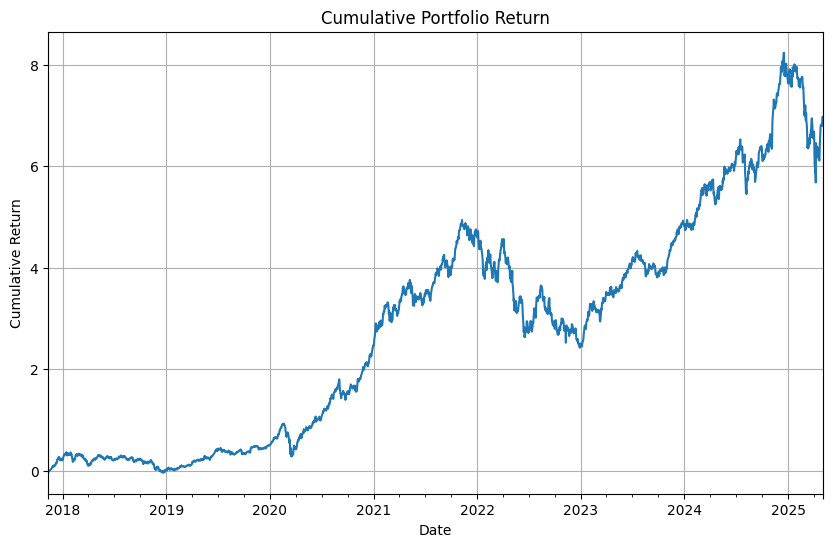

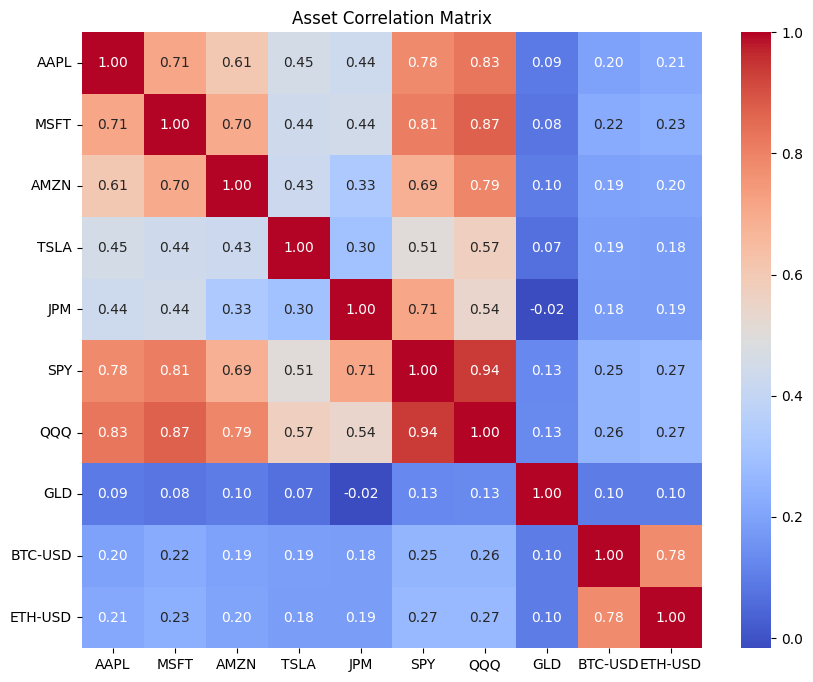

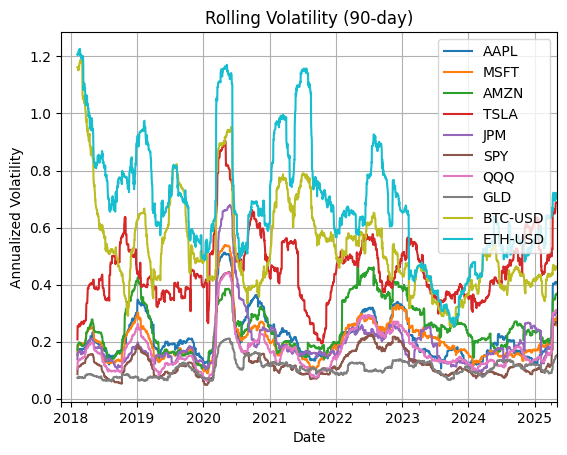

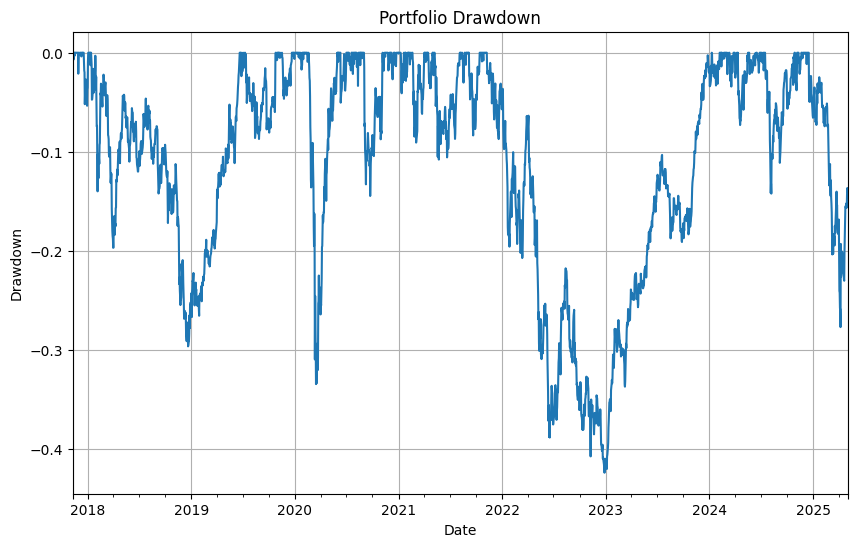

In [18]:
# Commulative Return
plt.figure(figsize=(10, 6)) 
cumulative_return.plot(title='Cumulative Portfolio Return') 
plt.xlabel('Date') 
plt.ylabel('Cumulative Return') 
plt.grid(True) 
plt.show()

# Heatmap
plt.figure(figsize=(10, 8)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f') 
plt.title('Asset Correlation Matrix') 
plt.show()

# Rolling Volatility
rolling_vol = daily_returns.rolling(window=90).std() * np.sqrt(total_trading_days) 
rolling_vol.plot(title='Rolling Volatility (90-day)') 
plt.ylabel('Annualized Volatility') 
plt.grid(True) 
plt.show()

# Drawdown Plot
plt.figure(figsize=(10, 6)) 
drawdown.plot(title='Portfolio Drawdown') 
plt.ylabel('Drawdown') 
plt.grid(True) 
plt.show()


#  **7.Optimized Challenge (Shape Ratio Maximization)**
- Used mean-variance optimization to **maximize the Sharpe Ratio**.
- Constrained weights to be between 0 and 1 and sum to 1.

In [20]:

def neg_sharpe(weights, returns, rf): 
    weights = np.array(weights) 
    port_return = np.dot(returns.mean(), weights) * total_trading_days 
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * total_trading_days, weights))) 
    return -(port_return - rf) / port_vol

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for _ in range(len(assets)))

initial_guess = np.array([1/len(assets)] * len(assets)) 
opt_result = minimize(neg_sharpe, initial_guess, args=(daily_returns, risk_free_rate), 
                      method='SLSQP', bounds=bounds, constraints=constraints)

optimized_weights = opt_result.x 
opt_portfolio_returns = daily_returns.dot(optimized_weights) 
opt_annualized_return = opt_portfolio_returns.mean() * total_trading_days
opt_annualized_volatility = opt_portfolio_returns.std() * np.sqrt(total_trading_days) 
opt_sharpe_ratio = (opt_annualized_return - risk_free_rate) / opt_annualized_volatility


# Summary Table

In [22]:

summary = pd.DataFrame({ 
    'Annualized Return': [annualized_return, opt_annualized_return], 
    'Annualized Volatility': [annualized_volatility, opt_annualized_volatility], 
    'Sharpe Ratio': [sharpe_ratio, opt_sharpe_ratio], 
    'Max Drawdown': [max_drawdown, compute_drawdown(opt_portfolio_returns).min()], 
    'Drawdown Duration': [drawdown_duration, (compute_drawdown(opt_portfolio_returns) < 0).astype(int).groupby((compute_drawdown(opt_portfolio_returns) == 0).astype(int).cumsum()).sum().max()]
}, index=['Initial Portfolio', 'Optimized Portfolio'])

print("\nPerformance Summary:") 
print(summary)


Performance Summary:
                     Annualized Return  Annualized Volatility  Sharpe Ratio  \
Initial Portfolio             0.213600               0.211604      0.796771   
Optimized Portfolio           0.191676               0.157050      0.933949   

                     Max Drawdown  Drawdown Duration  
Initial Portfolio       -0.423531                820  
Optimized Portfolio     -0.332158                743  


In [23]:
summary

,Annualized Return,Annualized Volatility,Sharpe Ratio,Max Drawdown,Drawdown Duration
Initial Portfolio,0.213600,0.211604,0.796771,-0.423531,820
Optimized Portfolio,0.191676,0.157050,0.933949,-0.332158,743


# Optimized Portfolio Visualizations


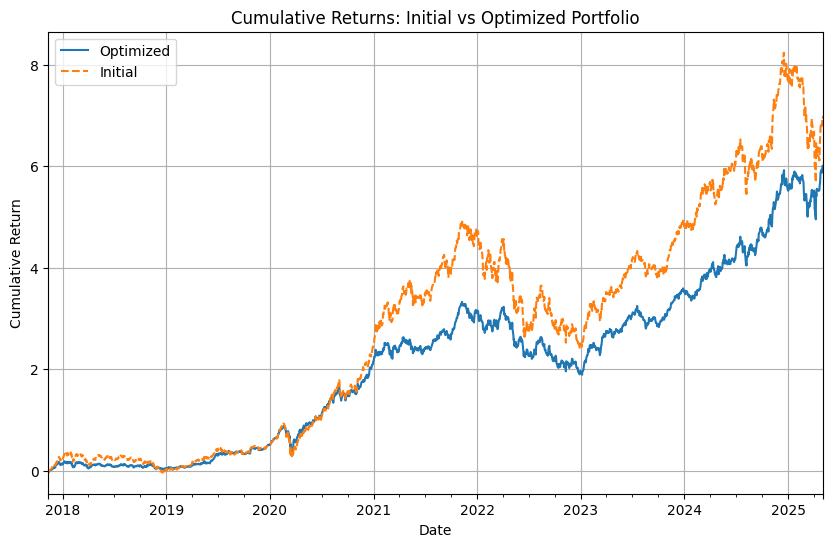

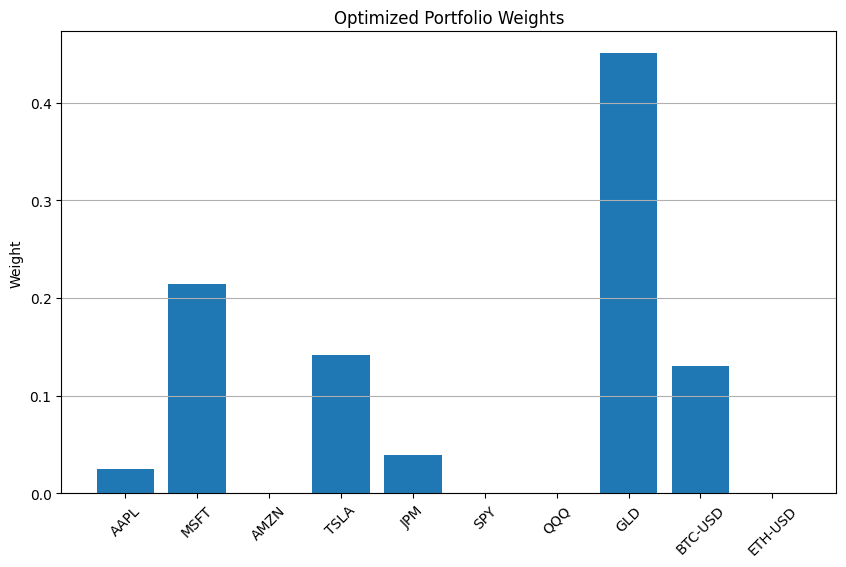

In [25]:
# Optimized cumulative return
opt_cumulative_return = (1 + opt_portfolio_returns).cumprod() - 1 
plt.figure(figsize=(10, 6)) 
opt_cumulative_return.plot(label='Optimized') 
cumulative_return.plot(label='Initial', linestyle='--') 
plt.title('Cumulative Returns: Initial vs Optimized Portfolio') 
plt.xlabel('Date') 
plt.ylabel('Cumulative Return') 
plt.legend() 
plt.grid(True) 
plt.show()

# Optimized weights bar plot
plt.figure(figsize=(10, 6)) 
plt.bar(assets, optimized_weights) 
plt.title('Optimized Portfolio Weights') 
plt.ylabel('Weight') 
plt.xticks(rotation=45) 
plt.grid(True, axis='y') 
plt.show()